In [1]:
from google.colab import drive
drive.mount('/content/drive/')



Mounted at /content/drive/


In [ ]:
!pwd

/content


In [2]:
#import 주석 처리해놓은 이유는 운레 python파일들로 저장 하는 것이었어서 #근데 train 코드 돌리려면 어차피 pythonn파일이 있어야 편함
# https://github.com/yangze0930/NTS-Net

import os
import torch.utils.data
from torch.nn import DataParallel
from datetime import datetime
from torch.optim.lr_scheduler import MultiStepLR
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
#from config import BATCH_SIZE, PROPOSAL_NUM, SAVE_FREQ, LR, WD, resume, save_dir
#from core import model, dataset
#from core.utils import init_log, progress_bar

In [3]:
#config.pyz
BATCH_SIZE = 4
PROPOSAL_NUM = 6
CAT_NUM = 4
INPUT_SIZE = (224, 224)  # (w, h) #원래는 (448,448)이지만 이미지 크기 (224,224)로 바꿈
LR = 0.001 #이것도 바꿀까 생각중
WD = 1e-4
SAVE_FREQ = 1
resume = ''
test_model = 'model.ckpt'
save_dir = '/model'

# Core 폴더

In [ ]:
# core 폴더의 dataset.py
# 이거 안쓰고 관우님 작성하신 것으로 하려고 함 
# 해당 dataset에 맞춘 것이기 때문에


import numpy as np
#import scipy.misc
import os
from PIL import Image
from torchvision import transforms
from config import INPUT_SIZE


class CUB():
    def __init__(self, root, is_train=True, data_len=None):
        self.root = root
        self.is_train = is_train
        img_txt_file = open(os.path.join(self.root, 'images.txt'))
        label_txt_file = open(os.path.join(self.root, 'image_class_labels.txt'))
        train_val_file = open(os.path.join(self.root, 'train_test_split.txt'))
        img_name_list = []
        for line in img_txt_file:
            img_name_list.append(line[:-1].split(' ')[-1])
        label_list = []
        for line in label_txt_file:
            label_list.append(int(line[:-1].split(' ')[-1]) - 1)
        train_test_list = []
        for line in train_val_file:
            train_test_list.append(int(line[:-1].split(' ')[-1]))
        train_file_list = [x for i, x in zip(train_test_list, img_name_list) if i]
        test_file_list = [x for i, x in zip(train_test_list, img_name_list) if not i]
        if self.is_train:
            self.train_img = [.imread(os.path.join(self.root, 'images', train_file)) for train_file in
                              train_file_list[:data_len]]
            self.train_label = [x for i, x in zip(train_test_list, label_list) if i][:data_len]
        if not self.is_train:
            self.test_img = [scipy.misc.imread(os.path.join(self.root, 'images', test_file)) for test_file in
                             test_file_list[:data_len]]
            self.test_label = [x for i, x in zip(train_test_list, label_list) if not i][:data_len]

    def __getitem__(self, index):
        if self.is_train:
            img, target = self.train_img[index], self.train_label[index]
            if len(img.shape) == 2:
                img = np.stack([img] * 3, 2)
            img = Image.fromarray(img, mode='RGB')
            img = transforms.Resize((600, 600), Image.BILINEAR)(img)
            img = transforms.RandomCrop(INPUT_SIZE)(img)#############################augmentation
            img = transforms.RandomHorizontalFlip()(img)
            img = transforms.ToTensor()(img)
            img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(img)

        else:
            img, target = self.test_img[index], self.test_label[index]
            if len(img.shape) == 2:
                img = np.stack([img] * 3, 2)
            img = Image.fromarray(img, mode='RGB')
            img = transforms.Resize((600, 600), Image.BILINEAR)(img)
            img = transforms.CenterCrop(INPUT_SIZE)(img)
            img = transforms.ToTensor()(img)
            img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(img)

        return img, target

    def __len__(self):
        if self.is_train:
            return len(self.train_label)
        else:
            return len(self.test_label)


if __name__ == '__main__':
    dataset = CUB(root='./CUB_200_2011')
    print(len(dataset.train_img))
    print(len(dataset.train_label))
    for data in dataset:
        print(data[0].size(), data[1])
    dataset = CUB(root='./CUB_200_2011', is_train=False)
    print(len(dataset.test_img))
    print(len(dataset.test_label))
    for data in dataset:
        print(data[0].size(), data[1])

SyntaxError: ignored

In [ ]:
cd content

/content


In [5]:
#관우님 것

#github은 dataset.py랑 밑의 train에 나눠져 있음 DataLoader 검색하면 train쪽에 있음을 알 수 있다

# 데이터셋을 불러올 때 사용할 변형(transformation) 객체 정의
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.RandomHorizontalFlip(), # augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 정규화(normalization)
])

transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = './drive/MyDrive/data_30'
train_datasets = datasets.ImageFolder(os.path.join(data_dir, 'Training'), transforms_train)
test_datasets = datasets.ImageFolder(os.path.join(data_dir, 'Test'), transforms_test)
val_datasets = datasets.ImageFolder(os.path.join(data_dir, 'Validation'), transforms_val)

train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=BATCH_SIZE , shuffle=True, num_workers=2)# 4->BATCH_SIZE 로
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=BATCH_SIZE , shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_datasets, batch_size=BATCH_SIZE , shuffle=True, num_workers=2)


###################################
############ K-Fold CV ############
###################################

#K-Fold cross-validation is very expensive because you run the model several times on different dataset folds

#그래서 k-fold 가 아니라 holdout을 써야할 것 같음....!!!!!!!!!!!!!!1

# 킽의 코드 간단하게는 https://www.machinecurve.com/index.php/2020/02/18/how-to-use-k-fold-cross-validation-with-keras/ 
#사용하면 될 것 같음.. 물론 적용을 해야하지만...

'''
for fold,(train_idx,test_idx) in enumerate(kfold.split(dataset)):
  print('------------fold no---------{}----------------------'.format(fold))
  train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
  test_subsampler = torch.utils.data.SubsetRandomSampler(test_idx)
 
  trainloader = torch.utils.data.DataLoader(
                      dataset, 
                      batch_size=batch_size, sampler=train_subsampler)
  testloader = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=batch_size, sampler=test_subsampler)
 
  model.apply(reset_weights)
 
  for epoch in range(1, epochs + 1):
    train(fold, model, device, trainloader, optimizer, epoch)
    test(fold,model, device, testloader)
'''

"\nfor fold,(train_idx,test_idx) in enumerate(kfold.split(dataset)):\n  print('------------fold no---------{}----------------------'.format(fold))\n  train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)\n  test_subsampler = torch.utils.data.SubsetRandomSampler(test_idx)\n \n  trainloader = torch.utils.data.DataLoader(\n                      dataset, \n                      batch_size=batch_size, sampler=train_subsampler)\n  testloader = torch.utils.data.DataLoader(\n                      dataset,\n                      batch_size=batch_size, sampler=test_subsampler)\n \n  model.apply(reset_weights)\n \n  for epoch in range(1, epochs + 1):\n    train(fold, model, device, trainloader, optimizer, epoch)\n    test(fold,model, device, testloader)\n"

In [ ]:
print('학습 데이터셋 크기:', len(train_datasets))
print('테스트 데이터셋 크기:', len(test_datasets))

class_names = train_datasets.classes
print('클래스:', class_names)

학습 데이터셋 크기: 3420
테스트 데이터셋 크기: 483
클래스: ['10013_해태갈배사이다355ML', '10015_롯데핫식스자몽250ML', '10016_동아오츠카데미소다자몽250ML', '10032_롯데마운틴듀355ML', '10033_코카환타포도250ML', '10034_코카콜라제로250ML', '10055_코카콜라355ML', '10056_롯데클라우드클리어제로(캔)350ML', '20004_롯데트로피카나스파클링사과355ML', '20012_롯데)레쓰비190ml', '25328_농심웰치스화이트그레이프맛355ML', '30010_롯데핫식스355ML', '30014_몬스터에너지울트라355ML', '30015_몬스터에너지그린355ML', '30017_롯데밀키스250ML', '30021_몬스터에너지파이프라인펀치355ML', '30033_코카콜라250ML', '30044_맥콜355ML', '40014_농심웰치스포도355ml', '40036_오란씨깔라만시250ML', '40049_코카환타오렌지250ML', '50012_일화맥콜250ML', '60001_롯데칠성사이다로어슈거250ml', '60009_롯데펩시콜라250ML', '60015_롯데트로피카나스파클링망고355ML', '60037_코카환타파인애플250ML', '80010_롯데칠성사이다190ML', '90020_동아데미소다애플250ML', '90040_해태)써니텐오렌지향250ML', '90

In [6]:
#core 폴더의 utils.py

from __future__ import print_function
import os
import sys
import time
import logging

#_, term_width = os.popen('stty size', 'r').read().split()# error 남 그래서 밑에로 #파이썬 파일에서도 고침
term_width = 80 #(set the term_width to 80 directly)
term_width = int(term_width)

TOTAL_BAR_LENGTH = 40.
last_time = time.time()
begin_time = last_time


def progress_bar(current, total, msg=None):
    global last_time, begin_time
    if current == 0:
        begin_time = time.time()  # Reset for new bar.

    cur_len = int(TOTAL_BAR_LENGTH * current / total)
    rest_len = int(TOTAL_BAR_LENGTH - cur_len) - 1

    sys.stdout.write(' [')
    for i in range(cur_len):
        sys.stdout.write('=')
    sys.stdout.write('>')
    for i in range(rest_len):
        sys.stdout.write('.')
    sys.stdout.write(']')

    cur_time = time.time()
    step_time = cur_time - last_time
    last_time = cur_time
    tot_time = cur_time - begin_time

    L = []
    L.append('  Step: %s' % format_time(step_time))
    L.append(' | Tot: %s' % format_time(tot_time))
    if msg:
        L.append(' | ' + msg)

    msg = ''.join(L)
    sys.stdout.write(msg)
    for i in range(term_width - int(TOTAL_BAR_LENGTH) - len(msg) - 3):
        sys.stdout.write(' ')

    # Go back to the center of the bar.
    for i in range(term_width - int(TOTAL_BAR_LENGTH / 2)):
        sys.stdout.write('\b')
    sys.stdout.write(' %d/%d ' % (current + 1, total))

    if current < total - 1:
        sys.stdout.write('\r')
    else:
        sys.stdout.write('\n')
    sys.stdout.flush()


def format_time(seconds):
    days = int(seconds / 3600 / 24)
    seconds = seconds - days * 3600 * 24
    hours = int(seconds / 3600)
    seconds = seconds - hours * 3600
    minutes = int(seconds / 60)
    seconds = seconds - minutes * 60
    secondsf = int(seconds)
    seconds = seconds - secondsf
    millis = int(seconds * 1000)

    f = ''
    i = 1
    if days > 0:
        f += str(days) + 'D'
        i += 1
    if hours > 0 and i <= 2:
        f += str(hours) + 'h'
        i += 1
    if minutes > 0 and i <= 2:
        f += str(minutes) + 'm'
        i += 1
    if secondsf > 0 and i <= 2:
        f += str(secondsf) + 's'
        i += 1
    if millis > 0 and i <= 2:
        f += str(millis) + 'ms'
        i += 1
    if f == '':
        f = '0ms'
    return f


def init_log(output_dir):
    logging.basicConfig(level=logging.DEBUG,
                        format='%(asctime)s %(message)s',
                        datefmt='%Y%m%d-%H:%M:%S',
                        filename=os.path.join(output_dir, 'log.log'),
                        filemode='w')
    console = logging.StreamHandler()
    console.setLevel(logging.INFO)
    logging.getLogger('').addHandler(console)
    return logging

if __name__ == '__main__':
    pass

In [7]:
#core 폴더의 anchor.py

#HTS-Net, github 에서 in[7]부터 In[83]까지 이해 안되면 뜯어보면서 공부 + In[8]의 def nms는 soft nms로 여기 코드의 hardnms랑 비교하면서 공부

import numpy as np
#from config import INPUT_SIZE

_default_anchors_setting = (#3부분?!!
    dict(layer='p3', stride=32, size=48, scale=[2 ** (1. / 3.), 2 ** (2. / 3.)], aspect_ratio=[0.667, 1, 1.5]),
    dict(layer='p4', stride=64, size=96, scale=[2 ** (1. / 3.), 2 ** (2. / 3.)], aspect_ratio=[0.667, 1, 1.5]),
    dict(layer='p5', stride=128, size=192, scale=[1, 2 ** (1. / 3.), 2 ** (2. / 3.)], aspect_ratio=[0.667, 1, 1.5]),
)


def generate_default_anchor_maps(anchors_setting=None, input_shape=INPUT_SIZE):
    """
    generate default anchor
    :param anchors_setting: all informations of anchors
    :param input_shape: shape of input images, e.g. (h, w)
    :return: center_anchors: # anchors * 4 (oy, ox, h, w)
             edge_anchors: # anchors * 4 (y0, x0, y1, x1)
             anchor_area: # anchors * 1 (area)
    """
    if anchors_setting is None:
        anchors_setting = _default_anchors_setting

    center_anchors = np.zeros((0, 4), dtype=np.float32)
    edge_anchors = np.zeros((0, 4), dtype=np.float32)
    anchor_areas = np.zeros((0,), dtype=np.float32)
    input_shape = np.array(input_shape, dtype=int)

    for anchor_info in anchors_setting:

        stride = anchor_info['stride']
        size = anchor_info['size']
        scales = anchor_info['scale']
        aspect_ratios = anchor_info['aspect_ratio']

        output_map_shape = np.ceil(input_shape.astype(np.float32) / stride) #np.ceil:소수점 올림!!->정수
        output_map_shape = output_map_shape.astype(np.int)
        output_shape = tuple(output_map_shape) + (4,)
        ostart = stride / 2.
        oy = np.arange(ostart, ostart + stride * output_shape[0], stride)
        oy = oy.reshape(output_shape[0], 1)
        ox = np.arange(ostart, ostart + stride * output_shape[1], stride)
        ox = ox.reshape(1, output_shape[1])
        center_anchor_map_template = np.zeros(output_shape, dtype=np.float32)
        center_anchor_map_template[:, :, 0] = oy
        center_anchor_map_template[:, :, 1] = ox
        for scale in scales:
            for aspect_ratio in aspect_ratios:
                center_anchor_map = center_anchor_map_template.copy()
                center_anchor_map[:, :, 2] = size * scale / float(aspect_ratio) ** 0.5
                center_anchor_map[:, :, 3] = size * scale * float(aspect_ratio) ** 0.5

                edge_anchor_map = np.concatenate((center_anchor_map[..., :2] - center_anchor_map[..., 2:4] / 2.,
                                                  center_anchor_map[..., :2] + center_anchor_map[..., 2:4] / 2.),
                                                 axis=-1)
                anchor_area_map = center_anchor_map[..., 2] * center_anchor_map[..., 3]
                center_anchors = np.concatenate((center_anchors, center_anchor_map.reshape(-1, 4)))
                edge_anchors = np.concatenate((edge_anchors, edge_anchor_map.reshape(-1, 4)))
                anchor_areas = np.concatenate((anchor_areas, anchor_area_map.reshape(-1)))

    return center_anchors, edge_anchors, anchor_areas

# IoU: https://deep-learning-study.tistory.com/402 
# predicted bounding box가 ground-truth bounding box와 얼마나 일치하는지 측정하기 위한 평가 지표를 정의
# area of overlap / area of union
def hard_nms(cdds, topn=10, iou_thresh=0.25): #non-maximum suppression
    #object detector가 예측한 bounding box 중에서 정확한 bounding box를 선택하도록 하는 기법
    #iou_thresh:한계점
    if not (type(cdds).__module__ == 'numpy' and len(cdds.shape) == 2 and cdds.shape[1] >= 5):
        raise TypeError('edge_box_map should be N * 5+ ndarray')

    cdds = cdds.copy()
    indices = np.argsort(cdds[:, 0])#모든 행 첫번째 열 #np.argsort:numpy array 정렬 #그래서 행이 총 3개면 [0,1,2]임
    cdds = cdds[indices]#cdds 그대로 가져옴 ###########이거 왜 필요하죠..? 그냥 cdds인데...
    cdd_results = []

    res = cdds

    while res.any():
        cdd = res[-1]# 마지막 행
        cdd_results.append(cdd)
        if len(cdd_results) == topn:
            return np.array(cdd_results)
        res = res[:-1] # 마지막 행 제외

        start_max = np.maximum(res[:, 1:3], cdd[1:3])# 두 개의 array에 대해 동일한 위치의 성분끼리 비교하여 최대값 또는 최소값 계산
        end_min = np.minimum(res[:, 3:5], cdd[3:5])
        lengths = end_min - start_max
        intersec_map = lengths[:, 0] * lengths[:, 1]
        intersec_map[np.logical_or(lengths[:, 0] < 0, lengths[:, 1] < 0)] = 0
        iou_map_cur = intersec_map / ((res[:, 3] - res[:, 1]) * (res[:, 4] - res[:, 2]) + (cdd[3] - cdd[1]) * (
            cdd[4] - cdd[2]) - intersec_map)
        res = res[iou_map_cur < iou_thresh]

    return np.array(cdd_results)


if __name__ == '__main__':
    a = hard_nms(np.array([
        [0.4, 1, 10, 12, 20],
        [0.5, 1, 11, 11, 20],
        [0.55, 20, 30, 40, 50]
    ]), topn=100, iou_thresh=0.4)
    print(a)

[[ 0.55 20.   30.   40.   50.  ]
 [ 0.5   1.   11.   11.   20.  ]]


In [8]:
#core폴더의 resnet.py
#resnet

#Batch normalization- Gradient 라는 것이 결국 미분값 즉 변화량을 의미하는데 
                    #이 변화량이 매우 작아지거나(Vanishing) 커진다면(Exploding) 신경망을 효과적으로 학습시키지 못하고, 
                    #Error rate 가 낮아지지 않고 수렴해버리는 문제가 발생
                    #기본적으로 정규화를 하는 이유는 학습을 더 빨리 하기 위해서 or Local optimum 문제에 빠지는 가능성을 줄이기 위해 사용
                    # 배치 정규화는 평균과 분산을 조정하는 과정이 별도의 과정으로 떼어진 것이 아니라, 
                        #신경망 안에 포함되어 학습 시 평균과 분산을 조정하는 과정
## https://m.blog.naver.com/laonple/220808903260

#resnet의 residual learning: residual mapping (잔차 매핑) 이 기존의 mapping보다 optimize(최적화) 하기 쉽다는 것을 가정


import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo

__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152']

model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample# downsampling:차원을 줄여서 적은 메모리로 깊은 convolution을 할 수 있게 한다. 
        # 보통 stride를 2 이상으로 하는 convolution을 사용하거나 pooling을 사용한다. 
        # 이 과정을 거치면 어쩔 수 없이 feature의 정보를 잃게된다.
        # https://m.blog.naver.com/9709193/221979612209
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4
    # 1x1-> 3x3 -> 1x1
    
    # Convolution Parameters = Kernel Size x Kernel Size x Input Channel x Output Channel
    #1x1 Convolution: 연산량이 작기 때문에 Feature Map(Output Channel)을 줄이거나 키울 때 사용
    #차원, 채널 축소 후 공간적 특성 추출(3x3 Convolution이 연산량이 9배 많기 때문에), 채널 증가, parameters 감소


    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)# If True, adds a learnable bias to the output.
        ## BatchNorm에 bias가 포함되어 있으므로, conv2d는 bias=False로 설정합니다.
        ## https://deep-learning-study.tistory.com/534
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)# num_features – C dimension from an expected input of size (N, C, H, W)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) #https://guru.tistory.com/70 예시:(1,1,64,64)->(1,1,32,32)
                                                                            #maxpool2d(2)일 때
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels#################
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        feature1 = x
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = nn.Dropout(p=0.5)(x)
        feature2 = x
        x = self.fc(x)

        return x, feature1, feature2


def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
    return model


def resnet34(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet34']))
    return model


def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
    return model


def resnet101(pretrained=False, **kwargs):
    """Constructs a ResNet-101 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet101']))
    return model


def resnet152(pretrained=False, **kwargs):
    """Constructs a ResNet-152 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet152']))
    return model

In [9]:
#core 폴더의 model.py

from torch import nn
import torch
import torch.nn.functional as F
from torch.autograd import Variable
#from core import resnet
import numpy as np
#from core.anchors import generate_default_anchor_maps, hard_nms
#from config import CAT_NUM, PROPOSAL_NUM





class ProposalNet(nn.Module): # attention proposal network / regional proposal network (RPN)##############################
    def __init__(self):
        super(ProposalNet, self).__init__()
        self.down1 = nn.Conv2d(2048, 128, 3, 1, 1)#torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, 
                                                  #padding=0, dilation=1, groups=1, bias=True, 
                                                  #padding_mode='zeros', device=None, dtype=None)
        self.down2 = nn.Conv2d(128, 128, 3, 2, 1)
        self.down3 = nn.Conv2d(128, 128, 3, 2, 1)
        self.ReLU = nn.ReLU()
        self.tidy1 = nn.Conv2d(128, 6, 1, 1, 0)
        self.tidy2 = nn.Conv2d(128, 6, 1, 1, 0)
        self.tidy3 = nn.Conv2d(128, 9, 1, 1, 0)

    def forward(self, x):
        batch_size = x.size(0)
        d1 = self.ReLU(self.down1(x))
        d2 = self.ReLU(self.down2(d1))
        d3 = self.ReLU(self.down3(d2))
        t1 = self.tidy1(d1).view(batch_size, -1)
        t2 = self.tidy2(d2).view(batch_size, -1)
        t3 = self.tidy3(d3).view(batch_size, -1)
        return torch.cat((t1, t2, t3), dim=1)


class attention_net(nn.Module):
    def __init__(self, topN=4):
        super(attention_net, self).__init__()
        self.pretrained_model = resnet50(pretrained=True)
        self.pretrained_model.avgpool = nn.AdaptiveAvgPool2d(1)
        #avg_pool2d에서 풀링 작업을 위한 커널과 보폭 크기를 정의하고 함수는 모든 유효한 입력에 대해 해당 작업을 수행합니다. 
        #예를 들어 kernel=3, stride=2, padding=0인 avg_pool2d는 5x5 텐서를 3x3 텐서로, 7x7 텐서를 4x4 텐서로 줄입니다.(HxW)
#adaptive_avg_pool2d에서 필요한 출력 크기를 정의합니다. 풀링 작업이 끝나면 pytorch가 이를 수행하는 데 사용할 풀링 매개변수를 유추합니다. 
#예를 들어 출력 크기가(3,3)인 adaptive_avg_pool2d는 5x5 및 7x7 텐서를 모두 3x3 텐서로 줄입니다.
        self.pretrained_model.fc = nn.Linear(512 * 4, 200) # nn.Linear(input_dim, output_dim)
        self.proposal_net = ProposalNet()
        self.topN = topN
        self.concat_net = nn.Linear(2048 * (CAT_NUM + 1), 200)
        self.partcls_net = nn.Linear(512 * 4, 200) #4 * 4 * 128
        _, edge_anchors, _ = generate_default_anchor_maps()
        self.pad_side = 224
        self.edge_anchors = (edge_anchors + 224).astype(np.int)

    def forward(self, x):
        resnet_out, rpn_feature, feature = self.pretrained_model(x)
        x_pad = F.pad(x, (self.pad_side, self.pad_side, self.pad_side, self.pad_side), mode='constant', value=0)
        batch = x.size(0)
        # we will reshape rpn to shape: batch * nb_anchor
        rpn_score = self.proposal_net(rpn_feature.detach())
        all_cdds = [
            np.concatenate((x.reshape(-1, 1), self.edge_anchors.copy(), np.arange(0, len(x)).reshape(-1, 1)), axis=1)
            for x in rpn_score.data.cpu().numpy()]
        top_n_cdds = [hard_nms(x, topn=self.topN, iou_thresh=0.25) for x in all_cdds]
        top_n_cdds = np.array(top_n_cdds)
        top_n_index = top_n_cdds[:, :, -1].astype(np.int)
        top_n_index = torch.from_numpy(top_n_index).cuda()
        top_n_prob = torch.gather(rpn_score, dim=1, index=top_n_index)
        part_imgs = torch.zeros([batch, self.topN, 3, 224, 224]).cuda()
        for i in range(batch):
            for j in range(self.topN):
                [y0, x0, y1, x1] = top_n_cdds[i][j, 1:5].astype(np.int)
                part_imgs[i:i + 1, j] = F.interpolate(x_pad[i:i + 1, :, y0:y1, x0:x1], size=(224, 224), mode='bilinear',
                                                      align_corners=True)
        part_imgs = part_imgs.view(batch * self.topN, 3, 224, 224)
        _, _, part_features = self.pretrained_model(part_imgs.detach())
        part_feature = part_features.view(batch, self.topN, -1)
        part_feature = part_feature[:, :CAT_NUM, ...].contiguous()
        part_feature = part_feature.view(batch, -1)
        # concat_logits have the shape: B*200
        concat_out = torch.cat([part_feature, feature], dim=1)
        concat_logits = self.concat_net(concat_out)
        raw_logits = resnet_out
        # part_logits have the shape: B*N*200
        part_logits = self.partcls_net(part_features).view(batch, self.topN, -1)
        return [raw_logits, concat_logits, part_logits, top_n_index, top_n_prob]


def list_loss(logits, targets):
    temp = F.log_softmax(logits, -1)
    loss = [-temp[i][targets[i].item()] for i in range(logits.size(0))]
    return torch.stack(loss)


def ranking_loss(score, targets, proposal_num=PROPOSAL_NUM):
    loss = Variable(torch.zeros(1).cuda())
    batch_size = score.size(0)
    for i in range(proposal_num):
        targets_p = (targets > targets[:, i].unsqueeze(1)).type(torch.cuda.FloatTensor)
        pivot = score[:, i].unsqueeze(1)
        loss_p = (1 - pivot + score) * targets_p
        loss_p = torch.sum(F.relu(loss_p))
        loss += loss_p
    return loss / batch_size

# train 시작

In [10]:
train_losses=[]
train_accues=[]
test_losses=[]
test_accues=[]


In [11]:
#train.py

# define model
import os
import torch.utils.data
#from core import model#, dataset
#from config import BATCH_SIZE, PROPOSAL_NUM, SAVE_FREQ, LR, WD, resume, save_dir
#from core.utils import init_log, progress_bar


start_epoch = 1
save_dir = os.path.join(save_dir, datetime.now().strftime('%Y%m%d_%H%M%S'))
if os.path.exists(save_dir):
    raise NameError('model dir exists!')
os.makedirs(save_dir)
logging = init_log(save_dir)
_print = logging.info



net = attention_net(topN=PROPOSAL_NUM)
if resume:
    ckpt = torch.load(resume)
    net.load_state_dict(ckpt['net_state_dict'])
    start_epoch = ckpt['epoch'] + 1
creterion = torch.nn.CrossEntropyLoss()

# define optimizers
raw_parameters = list(net.pretrained_model.parameters())
part_parameters = list(net.proposal_net.parameters())
concat_parameters = list(net.concat_net.parameters())
partcls_parameters = list(net.partcls_net.parameters())

raw_optimizer = torch.optim.SGD(raw_parameters, lr=LR, momentum=0.9, weight_decay=WD)
concat_optimizer = torch.optim.SGD(concat_parameters, lr=LR, momentum=0.9, weight_decay=WD)
part_optimizer = torch.optim.SGD(part_parameters, lr=LR, momentum=0.9, weight_decay=WD)
partcls_optimizer = torch.optim.SGD(partcls_parameters, lr=LR, momentum=0.9, weight_decay=WD)
schedulers = [MultiStepLR(raw_optimizer, milestones=[60, 100], gamma=0.1),
              MultiStepLR(concat_optimizer, milestones=[60, 100], gamma=0.1),
              MultiStepLR(part_optimizer, milestones=[60, 100], gamma=0.1),
              MultiStepLR(partcls_optimizer, milestones=[60, 100], gamma=0.1)]
net = net.cuda()#원래 net.cuda()
net = DataParallel(net)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
mv 001.ckpt /content/drive/MyDrive/

In [12]:
# 이어짐

for epoch in range(start_epoch, 11):
    for scheduler in schedulers:
        scheduler.step()

    # begin training
    _print('--' * 50)
    net.train()
    for i, data in enumerate(train_dataloader):#trainloader #관우님 것에 맞게 이름 바꿈
        img, label = data[0].cuda(), data[1].cuda()#data[0].cuda(), data[1].cuda() cuda가 안되는 관계로 cpu라 바끄ㅓㅆ는데...
        batch_size = img.size(0)
        raw_optimizer.zero_grad()
        part_optimizer.zero_grad()
        concat_optimizer.zero_grad()
        partcls_optimizer.zero_grad()

        raw_logits, concat_logits, part_logits, _, top_n_prob = net(img) #######Value Error 생김 
        
        #https://everyday-image-processing.tistory.com/86 보고 어떤 에러인지는 알아냄 근데 어디가 잘못인건지..
        
        part_loss = list_loss(part_logits.view(batch_size * PROPOSAL_NUM, -1),
                                    label.unsqueeze(1).repeat(1, PROPOSAL_NUM).view(-1)).view(batch_size, PROPOSAL_NUM)
        raw_loss = creterion(raw_logits, label)
        concat_loss = creterion(concat_logits, label)
        rank_loss = ranking_loss(top_n_prob, part_loss)
        partcls_loss = creterion(part_logits.view(batch_size * PROPOSAL_NUM, -1),
                                 label.unsqueeze(1).repeat(1, PROPOSAL_NUM).view(-1))

        total_loss = raw_loss + rank_loss + concat_loss + partcls_loss
        total_loss.backward()
        raw_optimizer.step()
        part_optimizer.step()
        concat_optimizer.step()
        partcls_optimizer.step()
        progress_bar(i, len(train_dataloader ), 'train')#trainloader

    if epoch % SAVE_FREQ == 0:
        train_loss = 0
        train_correct = 0
        total = 0
        net.eval()
        for i, data in enumerate(train_dataloader):#trainloader 
            with torch.no_grad():
                img, label = data[0].cuda(), data[1].cuda()#data[0].cuda(), data[1].cuda()
                batch_size = img.size(0)
                _, concat_logits, _, _, _ = net(img)
                # calculate loss
                concat_loss = creterion(concat_logits, label)
                # calculate accuracy
                _, concat_predict = torch.max(concat_logits, 1)
                total += batch_size
                train_correct += torch.sum(concat_predict.data == label.data)
                train_loss += concat_loss.item() * batch_size
                progress_bar(i, len(train_dataloader), 'eval train set')#trainloader

        train_acc = float(train_correct) / total
        train_loss = train_loss / total

        _print(
            'epoch:{} - train loss: {:.3f} and train acc: {:.3f} total sample: {}'.format(
                epoch,
                train_loss,
                train_acc,
                total))

# evaluate on test set
        test_loss = 0
        test_correct = 0
        total = 0
        for i, data in enumerate(test_dataloader):
            with torch.no_grad():
                img, label = data[0].cuda(), data[1].cuda()#data[0].cuda(), data[1].cuda()
                batch_size = img.size(0)
                _, concat_logits, _, _, _ = net(img)
                # calculate loss
                concat_loss = creterion(concat_logits, label)
                # calculate accuracy
                _, concat_predict = torch.max(concat_logits, 1)
                total += batch_size
                test_correct += torch.sum(concat_predict.data == label.data)
                test_loss += concat_loss.item() * batch_size
                progress_bar(i, len(test_dataloader), 'eval test set')

        test_acc = float(test_correct) / total
        test_loss = test_loss / total
        _print(
            'epoch:{} - test loss: {:.3f} and test acc: {:.3f} total sample: {}'.format(
                epoch,
                test_loss,
                test_acc,
                total))
        train_losses.append(train_loss)
        train_accues.append(train_acc)
        test_losses.append(test_loss)
        test_accues.append(test_acc)        

	# save model
        net_state_dict = net.module.state_dict()
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        torch.save({
            'epoch': epoch,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'test_loss': test_loss,
            'test_acc': test_acc,
            'net_state_dict': net_state_dict},
            os.path.join(save_dir, '%03d.ckpt' % epoch)) 

print('finishing training')

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
----------------------------------------------------------------------------------------------------
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(in

 [=======================================>]  Step: 1s84ms | Tot: 14m50s | train  855/855 
 [=======================================>]  Step: 592ms | Tot: 7m34s | eval train set 855/855 


epoch:1 - train loss: 0.074 and train acc: 0.976 total sample: 3420


 [=======================================>]  Step: 340ms | Tot: 1m14s | eval test set 121/121 


epoch:1 - test loss: 1.424 and test acc: 0.737 total sample: 483
----------------------------------------------------------------------------------------------------


 [=======================================>]  Step: 514ms | Tot: 8m23s | train    855/855 
 [=======================================>]  Step: 518ms | Tot: 7m33s | eval train set 855/855 


epoch:2 - train loss: 0.326 and train acc: 0.968 total sample: 3420


 [=======================================>]  Step: 104ms | Tot: 14s202ms | eval test set 121/121 


epoch:2 - test loss: 1.065 and test acc: 0.845 total sample: 483
----------------------------------------------------------------------------------------------------


 [=======================================>]  Step: 307ms | Tot: 8m21s | train    855/855 
 [=======================================>]  Step: 515ms | Tot: 7m31s | eval train set 855/855 


epoch:3 - train loss: 0.004 and train acc: 0.999 total sample: 3420


 [=======================================>]  Step: 92ms | Tot: 14s291ms | eval test set 121/121 


epoch:3 - test loss: 1.230 and test acc: 0.805 total sample: 483
----------------------------------------------------------------------------------------------------


 [=======================================>]  Step: 508ms | Tot: 8m22s | train    855/855 
 [=======================================>]  Step: 114ms | Tot: 7m30s | eval train set 855/855 


epoch:4 - train loss: 0.000 and train acc: 1.000 total sample: 3420


 [=======================================>]  Step: 91ms | Tot: 14s379ms | eval test set 121/121 


epoch:4 - test loss: 0.680 and test acc: 0.880 total sample: 483
----------------------------------------------------------------------------------------------------


 [=======================================>]  Step: 303ms | Tot: 8m20s | train    855/855 
 [=======================================>]  Step: 582ms | Tot: 7m32s | eval train set 855/855 


epoch:5 - train loss: 0.000 and train acc: 1.000 total sample: 3420


 [=======================================>]  Step: 101ms | Tot: 14s344ms | eval test set 121/121 


epoch:5 - test loss: 0.626 and test acc: 0.919 total sample: 483
----------------------------------------------------------------------------------------------------


 [=======================================>]  Step: 490ms | Tot: 8m20s | train    855/855 
 [=======================================>]  Step: 580ms | Tot: 7m31s | eval train set 855/855 


epoch:6 - train loss: 0.000 and train acc: 1.000 total sample: 3420


 [=======================================>]  Step: 96ms | Tot: 14s178ms | eval test set 121/121 


epoch:6 - test loss: 0.614 and test acc: 0.892 total sample: 483
----------------------------------------------------------------------------------------------------


 [=======================================>]  Step: 495ms | Tot: 8m21s | train    855/855 
 [=======================================>]  Step: 109ms | Tot: 7m31s | eval train set 855/855 


epoch:7 - train loss: 0.000 and train acc: 1.000 total sample: 3420


 [=======================================>]  Step: 96ms | Tot: 14s41ms | eval test set 121/121 


epoch:7 - test loss: 0.781 and test acc: 0.872 total sample: 483
----------------------------------------------------------------------------------------------------


 [=======================================>]  Step: 484ms | Tot: 8m21s | train    855/855 
 [=======================================>]  Step: 305ms | Tot: 7m32s | eval train set 855/855 


epoch:8 - train loss: 0.000 and train acc: 1.000 total sample: 3420


 [=======================================>]  Step: 93ms | Tot: 14s76ms | eval test set 121/121 


epoch:8 - test loss: 0.373 and test acc: 0.930 total sample: 483
----------------------------------------------------------------------------------------------------


 [=======================================>]  Step: 302ms | Tot: 8m21s | train    855/855 
 [=======================================>]  Step: 112ms | Tot: 7m33s | eval train set 855/855 


epoch:9 - train loss: 0.000 and train acc: 1.000 total sample: 3420


 [=======================================>]  Step: 96ms | Tot: 14s134ms | eval test set 121/121 


epoch:9 - test loss: 0.576 and test acc: 0.899 total sample: 483
----------------------------------------------------------------------------------------------------


 [=======================================>]  Step: 519ms | Tot: 8m22s | train    855/855 
 [=======================================>]  Step: 106ms | Tot: 7m32s | eval train set 855/855 


epoch:10 - train loss: 0.000 and train acc: 1.000 total sample: 3420


 [=======================================>]  Step: 99ms | Tot: 14s395ms | eval test set 121/121 


epoch:10 - test loss: 0.462 and test acc: 0.909 total sample: 483


finishing training


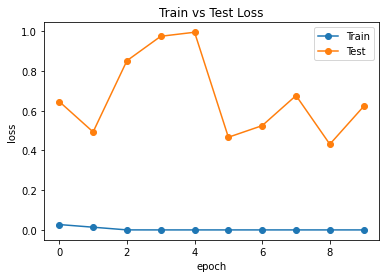

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_losses,'-o')
plt.plot(test_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','Test'])
plt.title('Train vs Test Loss')
 
plt.show()

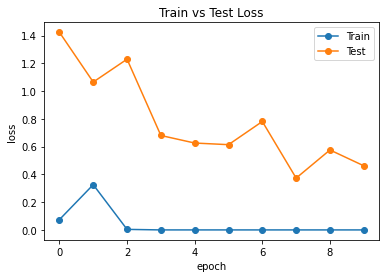

In [13]:
import matplotlib.pyplot as plt
plt.plot(train_losses,'-o')
plt.plot(test_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','Test'])
plt.title('Train vs Test Loss')
 
plt.show()

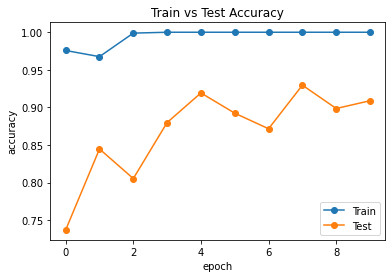

In [14]:
plt.plot(train_accues,'-o')
plt.plot(test_accues,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Test'])
plt.title('Train vs Test Accuracy')
 
plt.show()

In [ ]:
train_acc

1.0

In [ ]:
# 이어짐

for epoch in range(start_epoch, 11):
    for scheduler in schedulers:
        scheduler.step()

    # begin training
    _print('--' * 50)
    net.train()
    for i, data in enumerate(train_dataloader):#trainloader #관우님 것에 맞게 이름 바꿈
        img, label = data[0].cuda(), data[1].cuda()#data[0].cuda(), data[1].cuda() cuda가 안되는 관계로 cpu라 바끄ㅓㅆ는데...
        batch_size = img.size(0)
        raw_optimizer.zero_grad()
        part_optimizer.zero_grad()
        concat_optimizer.zero_grad()
        partcls_optimizer.zero_grad()

        raw_logits, concat_logits, part_logits, _, top_n_prob = net(img) #######Value Error 생김 
        
        #https://everyday-image-processing.tistory.com/86 보고 어떤 에러인지는 알아냄 근데 어디가 잘못인건지..
        
        part_loss = list_loss(part_logits.view(batch_size * PROPOSAL_NUM, -1),
                                    label.unsqueeze(1).repeat(1, PROPOSAL_NUM).view(-1)).view(batch_size, PROPOSAL_NUM)
        raw_loss = creterion(raw_logits, label)
        concat_loss = creterion(concat_logits, label)
        rank_loss = ranking_loss(top_n_prob, part_loss)
        partcls_loss = creterion(part_logits.view(batch_size * PROPOSAL_NUM, -1),
                                 label.unsqueeze(1).repeat(1, PROPOSAL_NUM).view(-1))

        total_loss = raw_loss + rank_loss + concat_loss + partcls_loss
        total_loss.backward()
        raw_optimizer.step()
        part_optimizer.step()
        concat_optimizer.step()
        partcls_optimizer.step()
        progress_bar(i, len(train_dataloader ), 'train')#trainloader

    if epoch % SAVE_FREQ == 0:
        train_loss = 0
        train_correct = 0
        total = 0
        net.eval()
        for i, data in enumerate(train_dataloader):#trainloader 
            with torch.no_grad():
                img, label = data[0].cuda(), data[1].cuda()#data[0].cuda(), data[1].cuda()
                batch_size = img.size(0)
                _, concat_logits, _, _, _ = net(img)
                # calculate loss
                concat_loss = creterion(concat_logits, label)
                # calculate accuracy
                _, concat_predict = torch.max(concat_logits, 1)
                total += batch_size
                train_correct += torch.sum(concat_predict.data == label.data)
                train_loss += concat_loss.item() * batch_size
                progress_bar(i, len(train_dataloader), 'eval train set')#trainloader

        train_acc = float(train_correct) / total
        train_loss = train_loss / total

        _print(
            'epoch:{} - train loss: {:.3f} and train acc: {:.3f} total sample: {}'.format(
                epoch,
                train_loss,
                train_acc,
                total))
        

# evaluate on test set
        val_loss = 0
        val_correct = 0
        total = 0
        for i, data in enumerate(val_dataloader):
            with torch.no_grad():
                img, label = data[0].cuda(), data[1].cuda()#data[0].cuda(), data[1].cuda()
                batch_size = img.size(0)
                _, concat_logits, _, _, _ = net(img)
                # calculate loss
                concat_loss = creterion(concat_logits, label)
                # calculate accuracy
                _, concat_predict = torch.max(concat_logits, 1)
                total += batch_size
                val_correct += torch.sum(concat_predict.data == label.data)
                val_loss += concat_loss.item() * batch_size
                progress_bar(i, len(val_dataloader), 'eval val set')

        val_acc = float(val_correct) / total
        val_loss = val_loss / total
        _print(
            'epoch:{} - val loss: {:.3f} and val acc: {:.3f} total sample: {}'.format(
                epoch,
                val_loss,
                val_acc,
                total))
        train_losses.append(train_loss)
        train_accues.append(train_correct)
        val_losses.append(val_loss)
        val_accues.append(val_correct)

	# save model
        net_state_dict = net.module.state_dict()
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        torch.save({
            'epoch': epoch,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'net_state_dict': net_state_dict},
            os.path.join(save_dir, '%03d.ckpt' % epoch))

print('finishing training')

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


KeyboardInterrupt: ignored